### 1. Objective

I'll be developing a machine learning model in this notebook to forecast the likelihood that a client will churn. It uses labelled training sets and supervised learning for classification, with an objective of 1 if the client churned and 0 otherwise.

#### 1.1 Steps

1. Import the libraries and dataset.
2. Feature selection.
3. Feature engineering, including feature scaling and feature enconding.
4. Split the dataset into training data (80%) and test data (20%).
5. Training and comparing models
6. Testing and assessment of the final production model.
7. Draw a conclusion and analyse the model's findings.
8. Deploy.

#### 2. Importing the libraries and dataset

In [2]:
# Ignore warnings
import warnings

warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# File management
import os
import pickle

# Modeling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import optuna
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score, accuracy_score, classification_report, roc_curve, precision_recall_curve, auc

In [32]:
df = pd.read_csv("dataset_churn.csv")
df_cleaned = pd.read_csv("dataset_churn_clean.csv")

In [33]:
df_cleaned.head()

,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [34]:
df_cleaned.rename(columns={'attrition_flag': 'churn_flag'}, inplace=True)
df_cleaned["churn_flag"] = df_cleaned["churn_flag"].map(
        {
            "Attrited Customer": 1,
            "Existing Customer": 0,
        }
    )

In [35]:
df_cleaned["income_category"].value_counts()

income_category
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: count, dtype: int64

In [36]:
X = df_cleaned.drop("churn_flag", axis=1)
y = df_cleaned["churn_flag"]

# dataset for tree-based models
X_tree = X.copy()
y_tree = y.copy()

#### 3. Feature engineering

##### Linear-based dataset

In [37]:
X['products_per_dependent'] = (X['total_relationship_count'] / X['dependent_count']).astype('float32')
X['trans_amt_per_dependent'] = (X['total_trans_amt'] / X['dependent_count']).astype('float32')
X['trans_ct_per_dependent'] = (X['total_trans_ct'] / (X['dependent_count'])).astype('float32')
X['trans_amt_per_products'] = (X['total_trans_amt'] / X['total_relationship_count']).astype('float32')
X['trans_ct_per_products'] = (X['total_trans_ct'] / X['total_relationship_count']).astype('float32')
X['avg_trans_amt'] = (X['total_trans_amt'] / X['total_trans_ct']).astype('float32')
X['credit_util_rate'] = (X['total_revolving_bal'] / X['credit_limit']).astype('float32')
X['proportion_inactive_months'] = (X['months_inactive_12_mon'] / X['months_on_book']).astype('float32')
X['products_per_tenure'] = (X['total_relationship_count'] / X['months_on_book']).astype('float32')
X['products_per_contacts'] = (X['total_relationship_count'] / (X['contacts_count_12_mon'])).astype('float32')
X['dependents_per_contacts'] = (X['dependent_count'] / X['contacts_count_12_mon']).astype('float32')
X['trans_ct_per_contacts'] = (X['total_trans_ct'] / X['contacts_count_12_mon']).astype('float32')
X['products_per_inactivity'] = (X['total_relationship_count'] / X['months_inactive_12_mon']).astype('float32')
X['dependents_per_inactivity'] = (X['dependent_count'] / X['months_inactive_12_mon']).astype('float32')
X['trans_ct_per_inactivity'] = (X['total_trans_ct'] / X['months_inactive_12_mon']).astype('float32')
X['trans_amt_per_credit_limit'] = (X['total_trans_amt'] / X['credit_limit']).astype('float32')
X['age_per_tenure'] = (X['customer_age'] / X['months_on_book']).astype('float32')
X['trans_ct_per_tenure'] = (X['total_trans_ct'] / X['months_on_book']).astype('float32')
X['trans_amt_per_tenure'] = (X['total_trans_amt'] / X['months_on_book']).astype('float32')
X = X.replace({
    np.inf: 0,
    np.nan: 0,
})
X['total_spending'] = (X['total_trans_amt'] + X['total_revolving_bal']).astype('int32')
X['inactivity_contacts'] = (X['months_inactive_12_mon'] + X['contacts_count_12_mon']).astype('int32')

In [38]:
X['education_level'] = X['education_level'].replace('Unknown', X['education_level'].mode()[0])
X['income_category'] = X['income_category'].replace('Unknown', X['income_category'].mode()[0])

In [39]:
# Undergraduate: 0, Graduate: 1, Post-Graduate: 2
education_mapping = {
    "Uneducated": 0,
    "High School": 0,
    "College": 0,
    "Graduate": 1,
    "Post-Graduate": 2,
    "Doctorate": 2,
}
income_mapping = {
    "Less than $40K": 0,
    "$40K - $60K": 1,
    "$60K - $80K": 2,
    "$80K - $120K": 3,
    "$120K +": 4,
}
X['education_numeric'] = X['education_level'].map(education_mapping).astype('int32')
X['income_numeric'] = X['income_category'].map(income_mapping).astype('int32')
X['education_income_levels'] = (X['education_numeric'] + X['income_numeric']).astype('int32')
X = X.drop(columns=['education_numeric', 'income_numeric'])

In [40]:
df_train = pd.concat([X, y], axis=1)
df_train.to_csv("dataset_churn_feature_eng.csv", index=True)

In [41]:
one_hot_feats = [
    "gender",
    "education_level",
    "marital_status",
    "income_category",
    "card_category",
]

ohe = OneHotEncoder(
    drop="first",
    sparse_output=False,
    dtype=np.int8,
    handle_unknown="ignore",
    feature_name_combiner="concat",
)

In [42]:
ohe.fit(X[one_hot_feats])

X_one_hot = ohe.transform(X[one_hot_feats])
one_hot_df = pd.DataFrame(
    X_one_hot, columns=ohe.get_feature_names_out(one_hot_feats)
)
X_reset = X.reset_index(drop=True)
X_encoded = pd.concat(
    [X_reset.drop(one_hot_feats, axis=1), one_hot_df], axis=1
)

In [43]:
std_scaling_feats = [
    "customer_age",
    "dependent_count",
    "months_on_book",
    "total_relationship_count",
    "months_inactive_12_mon",
    "contacts_count_12_mon",
    "credit_limit",
    "total_revolving_bal",
    "avg_open_to_buy",
    "total_amt_chng_q4_q1",
    "total_trans_amt",
    "total_trans_ct",
    "total_ct_chng_q4_q1",
    "products_per_dependent",
    "trans_amt_per_dependent",
    "trans_ct_per_dependent",
    "trans_amt_per_products",
    "trans_ct_per_products",
    "avg_trans_amt",
    "credit_util_rate",
    "proportion_inactive_months",
    "products_per_tenure",
    "products_per_contacts",
    "dependents_per_contacts",
    "trans_ct_per_contacts",
    "products_per_inactivity",
    "dependents_per_inactivity",
    "trans_ct_per_inactivity",
    "trans_amt_per_credit_limit",
    "age_per_tenure",
    "trans_ct_per_tenure",
    "trans_amt_per_tenure",
    "total_spending",
    "inactivity_contacts",
    "education_income_levels",
]
std_scaler = StandardScaler()
std_scaler.fit(X_encoded[std_scaling_feats])
x_scaled = std_scaler.transform(X_encoded[std_scaling_feats])
scaled_df = pd.DataFrame(x_scaled, columns=std_scaler.get_feature_names_out(std_scaling_feats))
X_reset = X_encoded.reset_index(drop=True)
X_scaled = pd.concat([X_reset.drop(std_scaling_feats, axis=1), scaled_df], axis=1)

In [44]:
X_scaled.drop(columns=['avg_open_to_buy'], inplace=True)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((8101, 51), (2026, 51))

In [46]:
X_train.head()

,avg_utilization_ratio,gender_M,education_level_Doctorate,education_level_Graduate,education_level_High School,education_level_Post-Graduate,education_level_Uneducated,marital_status_Married,marital_status_Single,marital_status_Unknown,income_category_$40K - $60K,income_category_$60K - $80K,income_category_$80K - $120K,income_category_Less than $40K,card_category_Gold,card_category_Platinum,card_category_Silver,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,products_per_dependent,trans_amt_per_dependent,trans_ct_per_dependent,trans_amt_per_products,trans_ct_per_products,avg_trans_amt,credit_util_rate,proportion_inactive_months,products_per_tenure,products_per_contacts,dependents_per_contacts,trans_ct_per_contacts,products_per_inactivity,dependents_per_inactivity,trans_ct_per_inactivity,trans_amt_per_credit_limit,age_per_tenure,trans_ct_per_tenure,trans_amt_per_tenure,total_spending,inactivity_contacts,education_income_levels
9066,0.464,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0.957290,-1.036462,0.008965,-1.809512,0.651940,0.492404,-0.540138,0.693525,-0.752480,1.221655,1.454591,-0.143747,-0.509148,2.863301,3.074894,2.641933,3.414234,0.901088,0.686495,0.426976,-1.447167,-1.139350,-0.809993,0.090735,-1.213586,-0.904164,-0.062898,1.338765,0.802503,0.906735,0.921209,1.330448,0.791716,-0.568918
5814,0.334,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1.456266,1.273283,1.511590,-1.809512,1.641478,0.492404,-0.356056,0.785555,-1.217817,-0.676218,-1.101710,-1.340852,-1.039799,-0.638118,-0.854150,0.122106,0.696196,-0.325232,0.214906,0.426976,-1.565054,-1.139350,0.269844,-0.768100,-1.274051,-0.236653,-1.068955,-0.694570,-0.510166,-1.217877,-0.752841,-0.467524,1.449553,-1.241904
792,0.103,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,-0.165406,1.273283,0.008965,1.407306,-1.327136,0.492404,0.809285,0.595359,-0.127469,-0.873747,-1.229525,2.258864,-0.155381,-0.711289,-0.887167,-0.607877,-0.798726,-0.860657,-0.623226,-1.183406,0.910561,0.248749,0.269844,-0.811042,2.898019,2.767147,0.066915,-1.015116,-0.322642,-1.012269,-0.787468,-0.700594,-0.523957,-0.568918
1791,0.694,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,-1.537589,-0.266547,0.008965,0.120579,0.651940,1.396424,-0.550921,1.661686,1.815998,-0.526378,-0.803475,2.468883,0.198386,-0.297344,-0.270846,-0.445803,-0.549572,-0.217520,1.521546,0.426976,-0.032530,-0.584110,-0.630020,-0.832513,-0.488009,-0.570408,-0.827357,-0.341474,-1.697819,-0.707665,-0.504209,-0.122433,1.449553,-0.568918
5011,0.708,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0.333570,-0.266547,0.384621,0.763943,0.651940,1.396424,-0.650500,0.936485,-0.720546,-0.176065,-0.164400,0.343496,0.552153,-0.037810,0.059325,-0.403904,-0.517862,-0.008305,1.571399,0.241163,0.257652,-0.375896,-0.630020,-0.671481,-0.246150,-0.570408,-0.611001,0.380975,-0.293792,-0.393689,-0.288828,0.046586,1.449553,-0.568918


##### Tree-based dataset

In [47]:
X_tree['products_per_dependent'] = (X_tree['total_relationship_count'] / X_tree['dependent_count']).astype('float32')
X_tree['trans_amt_per_dependent'] = (X_tree['total_trans_amt'] / X_tree['dependent_count']).astype('float32')
X_tree['trans_ct_per_dependent'] = (X_tree['total_trans_ct'] / (X_tree['dependent_count'])).astype('float32')
X_tree['trans_amt_per_products'] = (X_tree['total_trans_amt'] / X_tree['total_relationship_count']).astype('float32')
X_tree['trans_ct_per_products'] = (X_tree['total_trans_ct'] / X_tree['total_relationship_count']).astype('float32')
X_tree['avg_trans_amt'] = (X_tree['total_trans_amt'] / X_tree['total_trans_ct']).astype('float32')
X_tree['credit_util_rate'] = (X_tree['total_revolving_bal'] / X_tree['credit_limit']).astype('float32')
X_tree['proportion_inactive_months'] = (X_tree['months_inactive_12_mon'] / X_tree['months_on_book']).astype('float32')
X_tree['products_per_tenure'] = (X_tree['total_relationship_count'] / X_tree['months_on_book']).astype('float32')
X_tree['products_per_contacts'] = (X_tree['total_relationship_count'] / (X_tree['contacts_count_12_mon'])).astype('float32')
X_tree['dependents_per_contacts'] = (X_tree['dependent_count'] / X_tree['contacts_count_12_mon']).astype('float32')
X_tree['trans_ct_per_contacts'] = (X_tree['total_trans_ct'] / X_tree['contacts_count_12_mon']).astype('float32')
X_tree['products_per_inactivity'] = (X_tree['total_relationship_count'] / X_tree['months_inactive_12_mon']).astype('float32')
X_tree['dependents_per_inactivity'] = (X_tree['dependent_count'] / X_tree['months_inactive_12_mon']).astype('float32')
X_tree['trans_ct_per_inactivity'] = (X_tree['total_trans_ct'] / X_tree['months_inactive_12_mon']).astype('float32')
X_tree['trans_amt_per_credit_limit'] = (X_tree['total_trans_amt'] / X_tree['credit_limit']).astype('float32')
X_tree['age_per_tenure'] = (X_tree['customer_age'] / X_tree['months_on_book']).astype('float32')
X_tree['trans_ct_per_tenure'] = (X_tree['total_trans_ct'] / X_tree['months_on_book']).astype('float32')
X_tree['trans_amt_per_tenure'] = (X_tree['total_trans_amt'] / X_tree['months_on_book']).astype('float32')
X_tree = X_tree.replace({
    np.inf: 0,
    np.nan: 0,
})
X_tree['total_spending'] = (X_tree['total_trans_amt'] + X_tree['total_revolving_bal']).astype('int32')
X_tree['inactivity_contacts'] = (X_tree['months_inactive_12_mon'] + X_tree['contacts_count_12_mon']).astype('int32')

In [48]:
X_tree['education_level'] = X_tree['education_level'].replace('Unknown', X_tree['education_level'].mode()[0])
X_tree['income_category'] = X_tree['income_category'].replace('Unknown', X_tree['income_category'].mode()[0])

In [49]:
X_tree['education_numeric'] = X_tree['education_level'].map(education_mapping).astype('int32')
X_tree['income_numeric'] = X_tree['income_category'].map(income_mapping).astype('int32')
X_tree['education_income_levels'] = (X_tree['education_numeric'] + X_tree['income_numeric']).astype('int32')
X_tree = X_tree.drop(columns=['education_numeric', 'income_numeric'])

In [50]:
ohe.fit(X_tree[one_hot_feats])

X_one_hot = ohe.transform(X_tree[one_hot_feats])
one_hot_df = pd.DataFrame(
    X_one_hot, columns=ohe.get_feature_names_out(one_hot_feats)
)
X_reset = X_tree.reset_index(drop=True)
X_encoded = pd.concat(
    [X_reset.drop(one_hot_feats, axis=1), one_hot_df], axis=1
)

In [51]:
X_train_tree, X_test_tree, _, _ = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train_tree.shape, X_test_tree.shape

((8101, 52), (2026, 52))

In [52]:
X_train_tree.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8101 entries, 9066 to 7270
Data columns (total 52 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_age                    8101 non-null   int64  
 1   dependent_count                 8101 non-null   int64  
 2   months_on_book                  8101 non-null   int64  
 3   total_relationship_count        8101 non-null   int64  
 4   months_inactive_12_mon          8101 non-null   int64  
 5   contacts_count_12_mon           8101 non-null   int64  
 6   credit_limit                    8101 non-null   float64
 7   total_revolving_bal             8101 non-null   int64  
 8   avg_open_to_buy                 8101 non-null   float64
 9   total_amt_chng_q4_q1            8101 non-null   float64
 10  total_trans_amt                 8101 non-null   int64  
 11  total_trans_ct                  8101 non-null   int64  
 12  total_ct_chng_q4_q1             8101

In [53]:
X_train_tree.head()

,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,products_per_dependent,trans_amt_per_dependent,trans_ct_per_dependent,trans_amt_per_products,trans_ct_per_products,avg_trans_amt,credit_util_rate,proportion_inactive_months,products_per_tenure,products_per_contacts,dependents_per_contacts,trans_ct_per_contacts,products_per_inactivity,dependents_per_inactivity,trans_ct_per_inactivity,trans_amt_per_credit_limit,age_per_tenure,trans_ct_per_tenure,trans_amt_per_tenure,total_spending,inactivity_contacts,education_income_levels,gender_M,education_level_Doctorate,education_level_Graduate,education_level_High School,education_level_Post-Graduate,education_level_Uneducated,marital_status_Married,marital_status_Single,marital_status_Unknown,income_category_$40K - $60K,income_category_$60K - $80K,income_category_$80K - $120K,income_category_Less than $40K,card_category_Gold,card_category_Platinum,card_category_Silver
9066,54,1,36,1,3,3,3723.0,1728,1995.0,0.595,8554,99,0.678,0.464,1.00,8554.00,99.00,8554.000000,99.0,86.404037,0.464142,0.083333,0.027778,0.333333,0.333333,33.00,0.333333,0.333333,33.000000,2.297610,1.500000,2.750000,237.611115,10282,6,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
5814,58,4,48,1,4,3,5396.0,1803,3593.0,0.493,2107,39,0.393,0.334,0.25,526.75,9.75,2107.000000,39.0,54.025642,0.334136,0.083333,0.020833,0.333333,1.333333,13.00,0.250000,1.000000,9.750000,0.390474,1.208333,0.812500,43.895832,3910,7,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0
792,45,4,36,6,1,3,15987.0,1648,14339.0,0.732,1436,36,1.250,0.103,1.50,359.00,9.00,239.333328,6.0,39.888889,0.103084,0.027778,0.166667,2.000000,1.333333,12.00,6.000000,4.000000,36.000000,0.089823,1.250000,1.000000,39.888889,3084,4,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0
1791,34,2,36,4,3,4,3625.0,2517,1108.0,1.158,2616,46,1.300,0.694,2.00,1308.00,23.00,654.000000,11.5,56.869564,0.694345,0.083333,0.111111,1.000000,0.500000,11.50,1.333333,0.666667,15.333333,0.721655,0.944444,1.277778,72.666664,5133,7,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
5011,49,2,39,5,3,4,2720.0,1926,794.0,0.602,3806,61,0.794,0.708,2.50,1903.00,30.50,761.200012,12.2,62.393444,0.708088,0.076923,0.128205,1.250000,0.500000,15.25,1.666667,0.666667,20.333334,1.399265,1.256410,1.564103,97.589745,5732,7,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0


#### 4. Modeling 

##### Support Functions

In [54]:
results_df = pd.DataFrame(
    columns=["Model", "Precision", "Recall", "F1-Score", "Accuracy", "AUC"]
)

n_trials = 100

def model_report(model, y_true, y_pred):

    report = classification_report(y_test, y_pred, output_dict=True)
    precision = round(report["1"]["precision"], 2)
    recall = round(report["1"]["recall"], 2)
    f1_score = round(report["1"]["f1-score"], 2)
    accuracy = round(accuracy_score(y_true, y_pred), 2)
    auc = round(roc_auc_score(y_true, y_pred), 2)

    results_df.loc[len(results_df)] = [
        model.__class__.__name__,
        precision,
        recall,
        f1_score,
        accuracy,
        auc,
    ]

    print("\n Classification Report:")
    print(classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_matrix, display_labels=model.classes_
    )
    disp.plot()
    plt.show()

##### Logistic Regression

In [55]:
def objective(trial):
    param = {
        "tol": trial.suggest_uniform("tol", 1e-6, 1e-3),
        "C": trial.suggest_loguniform("C", 1e-2, 1),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "solver": trial.suggest_categorical(
            "solver",
            ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
        ),
        "random_state": 42,
        "n_jobs": -1,
    }

    log_reg = LogisticRegression(**param)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_auc_scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        log_reg.fit(X_train_fold, y_train_fold)
        y_pred = log_reg.predict(X_val_fold)
        roc_auc_scores.append(roc_auc_score(y_val_fold, y_pred))

    return np.mean(roc_auc_scores)

In [56]:
logreg_study = optuna.create_study(direction="maximize")
logreg_study.optimize(objective, n_trials=n_trials)

[I 2024-08-27 15:12:42,915] A new study created in memory with name: no-name-5ea2dccc-1edd-4eea-ba8d-44b05d572a6e
[I 2024-08-27 15:12:43,154] Trial 0 finished with value: 0.7932215133269721 and parameters: {'tol': 0.0007784722688055414, 'C': 0.028223557831689273, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 0 with value: 0.7932215133269721.
[I 2024-08-27 15:12:48,479] Trial 1 finished with value: 0.787746508256838 and parameters: {'tol': 0.0005043825340309252, 'C': 0.016366615989778135, 'fit_intercept': False, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.7932215133269721.
[I 2024-08-27 15:12:49,460] Trial 2 finished with value: 0.8073843552285549 and parameters: {'tol': 0.0009080698337879449, 'C': 0.13626822532126667, 'fit_intercept': True, 'solver': 'sag'}. Best is trial 2 with value: 0.8073843552285549.
[I 2024-08-27 15:12:53,799] Trial 3 finished with value: 0.8112813600260654 and parameters: {'tol': 0.000488643479261839, 'C': 0.30495521876135917, 'fit_inte

In [57]:
best_params_logreg = logreg_study.best_params
logreg_model = LogisticRegression(**best_params_logreg, random_state=42, n_jobs=-1)
logreg_model.fit(X_train, y_train)
y_pred_logreg = logreg_model.predict(X_test)


 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1699
           1       0.78      0.64      0.70       327

    accuracy                           0.91      2026
   macro avg       0.86      0.80      0.83      2026
weighted avg       0.91      0.91      0.91      2026



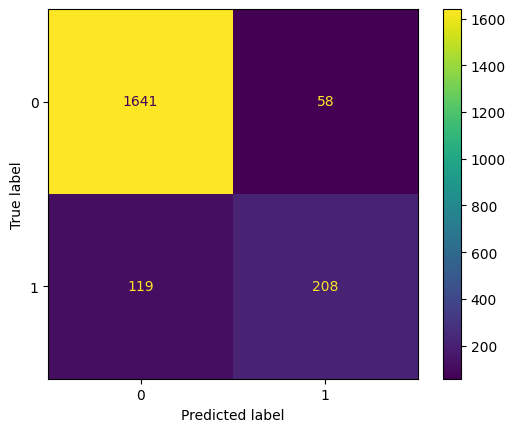

In [58]:
model_report(logreg_model, y_test, y_pred_logreg)

##### LinearSVC

In [59]:
def objective(trial):
    param = {
        "tol": trial.suggest_uniform("tol", 1e-6, 1e-3),
        "C": trial.suggest_loguniform("C", 1e-2, 1),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "loss": trial.suggest_categorical("loss", ["hinge", "squared_hinge"]),
        "random_state": 42,
    }

    svc = LinearSVC(**param)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_auc_scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        svc.fit(X_train_fold, y_train_fold)
        y_pred = svc.predict(X_val_fold)
        roc_auc_scores.append(roc_auc_score(y_val_fold, y_pred))

    return np.mean(roc_auc_scores)

In [60]:
svc_study = optuna.create_study(direction="maximize")
svc_study.optimize(objective, n_trials=n_trials)

[I 2024-08-27 15:13:58,442] A new study created in memory with name: no-name-464860b1-5c8a-4314-86ab-1deff9ad03e3
[I 2024-08-27 15:13:58,741] Trial 0 finished with value: 0.8099125817455224 and parameters: {'tol': 0.00022173557241707148, 'C': 0.04159313677758955, 'fit_intercept': True, 'loss': 'squared_hinge'}. Best is trial 0 with value: 0.8099125817455224.
[I 2024-08-27 15:13:58,863] Trial 1 finished with value: 0.7946236879989095 and parameters: {'tol': 0.0004262072151376008, 'C': 0.014753140184721347, 'fit_intercept': False, 'loss': 'hinge'}. Best is trial 0 with value: 0.8099125817455224.
[I 2024-08-27 15:13:58,995] Trial 2 finished with value: 0.8032663299875988 and parameters: {'tol': 0.0004352841425886644, 'C': 0.09221272097509602, 'fit_intercept': False, 'loss': 'hinge'}. Best is trial 0 with value: 0.8099125817455224.
[I 2024-08-27 15:13:59,130] Trial 3 finished with value: 0.8023896331550198 and parameters: {'tol': 0.00018314850114134704, 'C': 0.03759153043141911, 'fit_inter

In [61]:
best_params_svc = svc_study.best_params
svc_model = LinearSVC(**best_params_svc, random_state=42)
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)


 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1699
           1       0.79      0.61      0.69       327

    accuracy                           0.91      2026
   macro avg       0.86      0.79      0.82      2026
weighted avg       0.91      0.91      0.91      2026



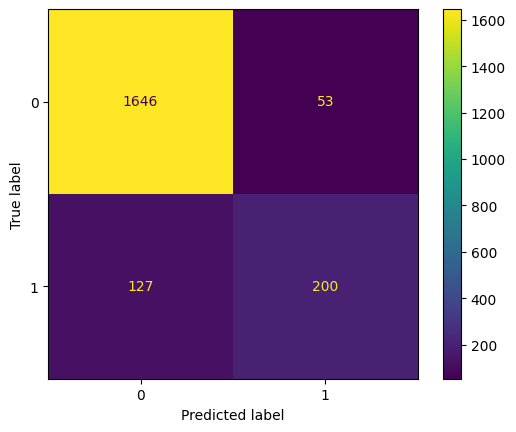

In [62]:
model_report(svc_model, y_test, y_pred_svc)

##### KNN

In [63]:
def objective(trial):
    param = {
        "n_neighbors": trial.suggest_int("n_neighbors", 3, 15),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "algorithm": trial.suggest_categorical("algorithm", ["ball_tree", "kd_tree"]),
        "leaf_size": trial.suggest_int("leaf_size", 10, 50),
        "n_jobs": -1,
    }

    knn = KNeighborsClassifier(**param)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_auc_scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        knn.fit(X_train_fold, y_train_fold)
        y_pred = knn.predict(X_val_fold)
        roc_auc_scores.append(roc_auc_score(y_val_fold, y_pred))

    return np.mean(roc_auc_scores)

In [64]:
knn_study = optuna.create_study(direction="maximize")
knn_study.optimize(objective, n_trials=n_trials)

[I 2024-08-27 15:14:31,221] A new study created in memory with name: no-name-5a4ac5fd-fd56-43d6-91fd-f6b69ab69566
[I 2024-08-27 15:14:32,698] Trial 0 finished with value: 0.8187981662738005 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 45}. Best is trial 0 with value: 0.8187981662738005.
[I 2024-08-27 15:14:34,405] Trial 1 finished with value: 0.8152964407658729 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 26}. Best is trial 0 with value: 0.8187981662738005.
[I 2024-08-27 15:14:35,891] Trial 2 finished with value: 0.81851465850569 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 31}. Best is trial 0 with value: 0.8187981662738005.
[I 2024-08-27 15:14:37,664] Trial 3 finished with value: 0.7916983993337345 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 46}. Best is trial 0 with value: 0.81879

In [65]:
best_params_knn = knn_study.best_params
knn_model = KNeighborsClassifier(**best_params_knn,)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)


 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1699
           1       0.81      0.62      0.70       327

    accuracy                           0.92      2026
   macro avg       0.87      0.80      0.83      2026
weighted avg       0.91      0.92      0.91      2026



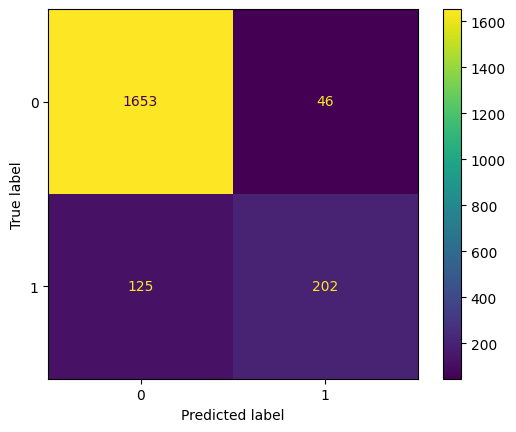

In [66]:
model_report(knn_model, y_test, y_pred_knn)

##### Decision Tree

In [67]:
def objective(trial):
    param = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "splitter": trial.suggest_categorical("splitter", ["best", "random"]),
        "max_depth": trial.suggest_int("max_depth", 5, 15),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "min_weight_fraction_leaf": trial.suggest_float(
            "min_weight_fraction_leaf", 0.0, 0.5
        ),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "random_state": 42,
    }

    tree = DecisionTreeClassifier(**param)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_auc_scores = []

    for train_index, val_index in kf.split(X_train_tree, y_train):
        X_train_fold, X_val_fold = X_train_tree.iloc[train_index], X_train_tree.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        tree.fit(X_train_fold, y_train_fold)
        y_pred = tree.predict(X_val_fold)
        roc_auc_scores.append(roc_auc_score(y_val_fold, y_pred))

    return np.mean(roc_auc_scores)

In [68]:
tree_study = optuna.create_study(direction="maximize")
tree_study.optimize(objective, n_trials=n_trials)

[I 2024-08-27 15:17:07,215] A new study created in memory with name: no-name-df34e65d-9649-4079-a7c0-3fe46d42af1e
[I 2024-08-27 15:17:07,288] Trial 0 finished with value: 0.5 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.44141273567988726, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5.
[I 2024-08-27 15:17:07,363] Trial 1 finished with value: 0.5 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.21189670088913976, 'max_features': 'log2'}. Best is trial 0 with value: 0.5.
[I 2024-08-27 15:17:07,424] Trial 2 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.35411241190388837, 'max_features': 'log2'}. Best is trial 0 with value: 0.5.
[I 2024-08-27 

In [69]:
best_params_tree = tree_study.best_params
tree_model = DecisionTreeClassifier(**best_params_tree, random_state=42)
tree_model.fit(X_train_tree, y_train)
y_pred_tree = tree_model.predict(X_test_tree)


 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1699
           1       0.54      0.51      0.52       327

    accuracy                           0.85      2026
   macro avg       0.72      0.71      0.72      2026
weighted avg       0.85      0.85      0.85      2026



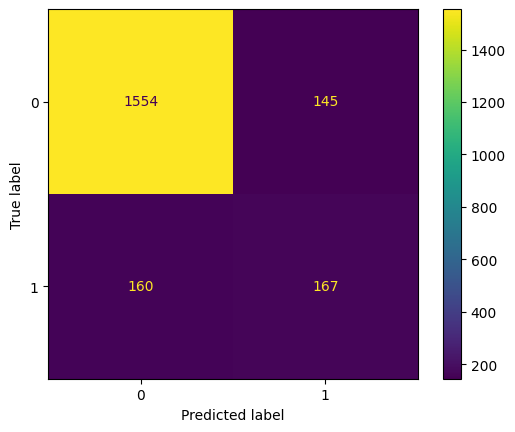

In [70]:
model_report(tree_model, y_test, y_pred_tree)

##### Random Forest

In [71]:
def objective(trial):
    param = {
        "criterion": "gini",
        "max_features": "sqrt",
        "n_estimators": trial.suggest_int("n_estimators", 512, 1024),
        "max_depth": trial.suggest_int("max_depth", 8, 32),
        "min_samples_split": trial.suggest_int("min_samples_split", 4, 12),
        "random_state": 42,
        "n_jobs": -1,
    }

    rf = RandomForestClassifier(**param)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_auc_scores = []

    for train_index, val_index in kf.split(X_train_tree, y_train):
        X_train_fold, X_val_fold = X_train_tree.iloc[train_index], X_train_tree.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        rf.fit(X_train_fold, y_train_fold)
        y_pred = rf.predict(X_val_fold)
        roc_auc_scores.append(roc_auc_score(y_val_fold, y_pred))

    return np.mean(roc_auc_scores)

In [72]:
rf_study = optuna.create_study(direction="maximize")
rf_study.optimize(objective, n_trials=n_trials)

[I 2024-08-27 15:17:16,508] A new study created in memory with name: no-name-5a9d5b8c-aa1a-4dad-92ae-2f3e3d8e17ee
[I 2024-08-27 15:17:30,289] Trial 0 finished with value: 0.8976541736346378 and parameters: {'n_estimators': 962, 'max_depth': 25, 'min_samples_split': 11}. Best is trial 0 with value: 0.8976541736346378.
[I 2024-08-27 15:17:41,225] Trial 1 finished with value: 0.9011157120961762 and parameters: {'n_estimators': 781, 'max_depth': 24, 'min_samples_split': 5}. Best is trial 1 with value: 0.9011157120961762.
[I 2024-08-27 15:17:50,403] Trial 2 finished with value: 0.8955670155362208 and parameters: {'n_estimators': 656, 'max_depth': 32, 'min_samples_split': 12}. Best is trial 1 with value: 0.9011157120961762.
[I 2024-08-27 15:18:01,056] Trial 3 finished with value: 0.893112264404999 and parameters: {'n_estimators': 740, 'max_depth': 12, 'min_samples_split': 6}. Best is trial 1 with value: 0.9011157120961762.
[I 2024-08-27 15:18:12,838] Trial 4 finished with value: 0.8985704092

In [73]:
best_params_rf = rf_study.best_params
rf_model = RandomForestClassifier(**best_params_rf, n_jobs=-1, random_state=42, criterion="gini", max_features="sqrt")
rf_model.fit(X_train_tree, y_train)
y_pred_rf = rf_model.predict(X_test_tree)


 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1699
           1       0.95      0.80      0.87       327

    accuracy                           0.96      2026
   macro avg       0.96      0.89      0.92      2026
weighted avg       0.96      0.96      0.96      2026



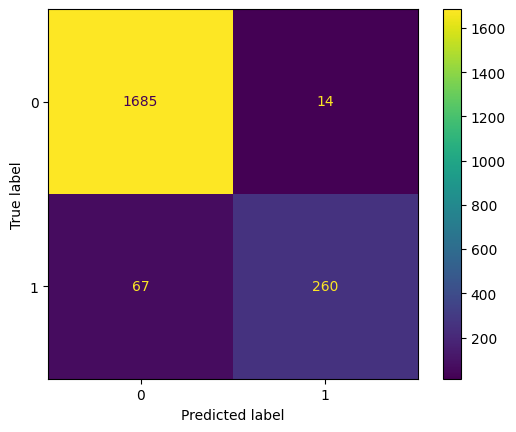

In [74]:
model_report(rf_model, y_test, y_pred_rf)

##### LightGBM

In [75]:
def objective(trial):
    param = {
        "objective": "binary",
        #tree strucure params
        "num_leaves": trial.suggest_int("num_leaves", 512, 3072),
        "max_depth": trial.suggest_int("max_depth", 4, 32),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 512, 1024),
        #accuracy params
        "n_estimators": trial.suggest_int("n_estimators", (512), (1024)),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.03),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        #overfitting params
        "reg_alpha": trial.suggest_int("reg_alpha", 1, 50),
        "reg_lambda": trial.suggest_int("reg_lambda", 1, 50),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 0.9),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 0.9),
        # others
        "random_state": 42,
        "n_jobs": -2,
        "verbosity": -1,
        "verbose": 0,
    }

    lgbm = LGBMClassifier(**param)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_auc_scores = []

    for train_index, val_index in kf.split(X_train_tree, y_train):
        X_train_fold, X_val_fold = X_train_tree.iloc[train_index], X_train_tree.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        lgbm.fit(
            X_train_fold,
            y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            eval_metric="auc",
        )

        y_pred_fold = lgbm.predict_proba(X_val_fold)[:, 1]
        roc_auc_scores.append(roc_auc_score(y_val_fold, y_pred_fold))

    return np.mean(roc_auc_scores)

In [76]:
lgbm_study = optuna.create_study(direction="maximize")
lgbm_study.optimize(objective, n_trials=n_trials)

[I 2024-08-27 15:32:48,989] A new study created in memory with name: no-name-fa86a34a-1853-4eb3-80b1-98d07795c363
[I 2024-08-27 15:33:05,157] Trial 0 finished with value: 0.5 and parameters: {'num_leaves': 771, 'max_depth': 8, 'min_data_in_leaf': 848, 'n_estimators': 1014, 'learning_rate': 0.027069550401082075, 'max_bin': 286, 'reg_alpha': 30, 'reg_lambda': 11, 'min_gain_to_split': 14.550468153942033, 'bagging_fraction': 0.22134784431813143, 'bagging_freq': 10, 'feature_fraction': 0.607912287788262}. Best is trial 0 with value: 0.5.
[I 2024-08-27 15:33:15,407] Trial 1 finished with value: 0.9012556681605555 and parameters: {'num_leaves': 2535, 'max_depth': 27, 'min_data_in_leaf': 594, 'n_estimators': 583, 'learning_rate': 0.027807795870333114, 'max_bin': 298, 'reg_alpha': 22, 'reg_lambda': 14, 'min_gain_to_split': 6.465588749252504, 'bagging_fraction': 0.2541004439950051, 'bagging_freq': 10, 'feature_fraction': 0.45084444837880644}. Best is trial 1 with value: 0.9012556681605555.
[I 20

In [77]:
best_params_lgbm = lgbm_study.best_params
lgbm_model =  LGBMClassifier(**best_params_lgbm, n_jobs=-1, random_state=42, verbosity=-1, verbose=0)
lgbm_model.fit(X_train_tree, y_train)
y_pred_lgbm = lgbm_model.predict(X_test_tree)


 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1699
           1       0.91      0.86      0.89       327

    accuracy                           0.96      2026
   macro avg       0.94      0.92      0.93      2026
weighted avg       0.96      0.96      0.96      2026



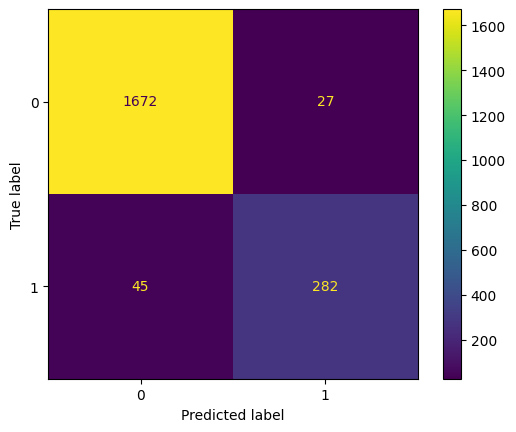

In [78]:
model_report(lgbm_model, y_test, y_pred_lgbm)

##### Save Models

In [79]:
folder_path = os.path.join(os.getcwd(), "artifacts")
X_test.to_csv(os.path.join(folder_path, f"test.csv"), index=True)
X_test_tree.to_csv(os.path.join(folder_path, f"test_tree.csv"), index=True)
y_test.to_csv(os.path.join(folder_path, f"test_target.csv"), index=True)

In [80]:
models = [logreg_model, svc_model, knn_model, tree_model, rf_model, lgbm_model]
names = [model.__class__.__name__ for model in models]

for model, name in zip(models, names):
    with open(os.path.join(folder_path, f"{name}.pkl"), "wb") as file:
        pickle.dump(model, file)
        
results_df.to_csv(os.path.join(folder_path, "results.csv"), index=False)

#### 5. Evaluation

In [3]:
results = pd.read_csv("./artifacts/results.csv")
results

,Model,Precision,Recall,F1-Score,Accuracy,AUC
0,LogisticRegression,0.78,0.64,0.70,0.91,0.80
1,LinearSVC,0.79,0.61,0.69,0.91,0.79
2,KNeighborsClassifier,0.81,0.62,0.70,0.92,0.80
3,DecisionTreeClassifier,0.54,0.51,0.52,0.85,0.71
4,RandomForestClassifier,0.95,0.80,0.87,0.96,0.89
5,LGBMClassifier,0.91,0.86,0.89,0.96,0.92


The LGBMClassifier is the most effective model for this assignment, according on the performance criteria shown in the table. It has the greatest *F1-Score* (0.89), indicating a well-balanced *precision* (0.91) and *recall* (0.86), indicating that it is a reliable model for identifying genuine positives and minimising false positives. It also obtains the greatest *AUC* (0.92), demonstrating its effectiveness in class distinction over a range of decision criteria.

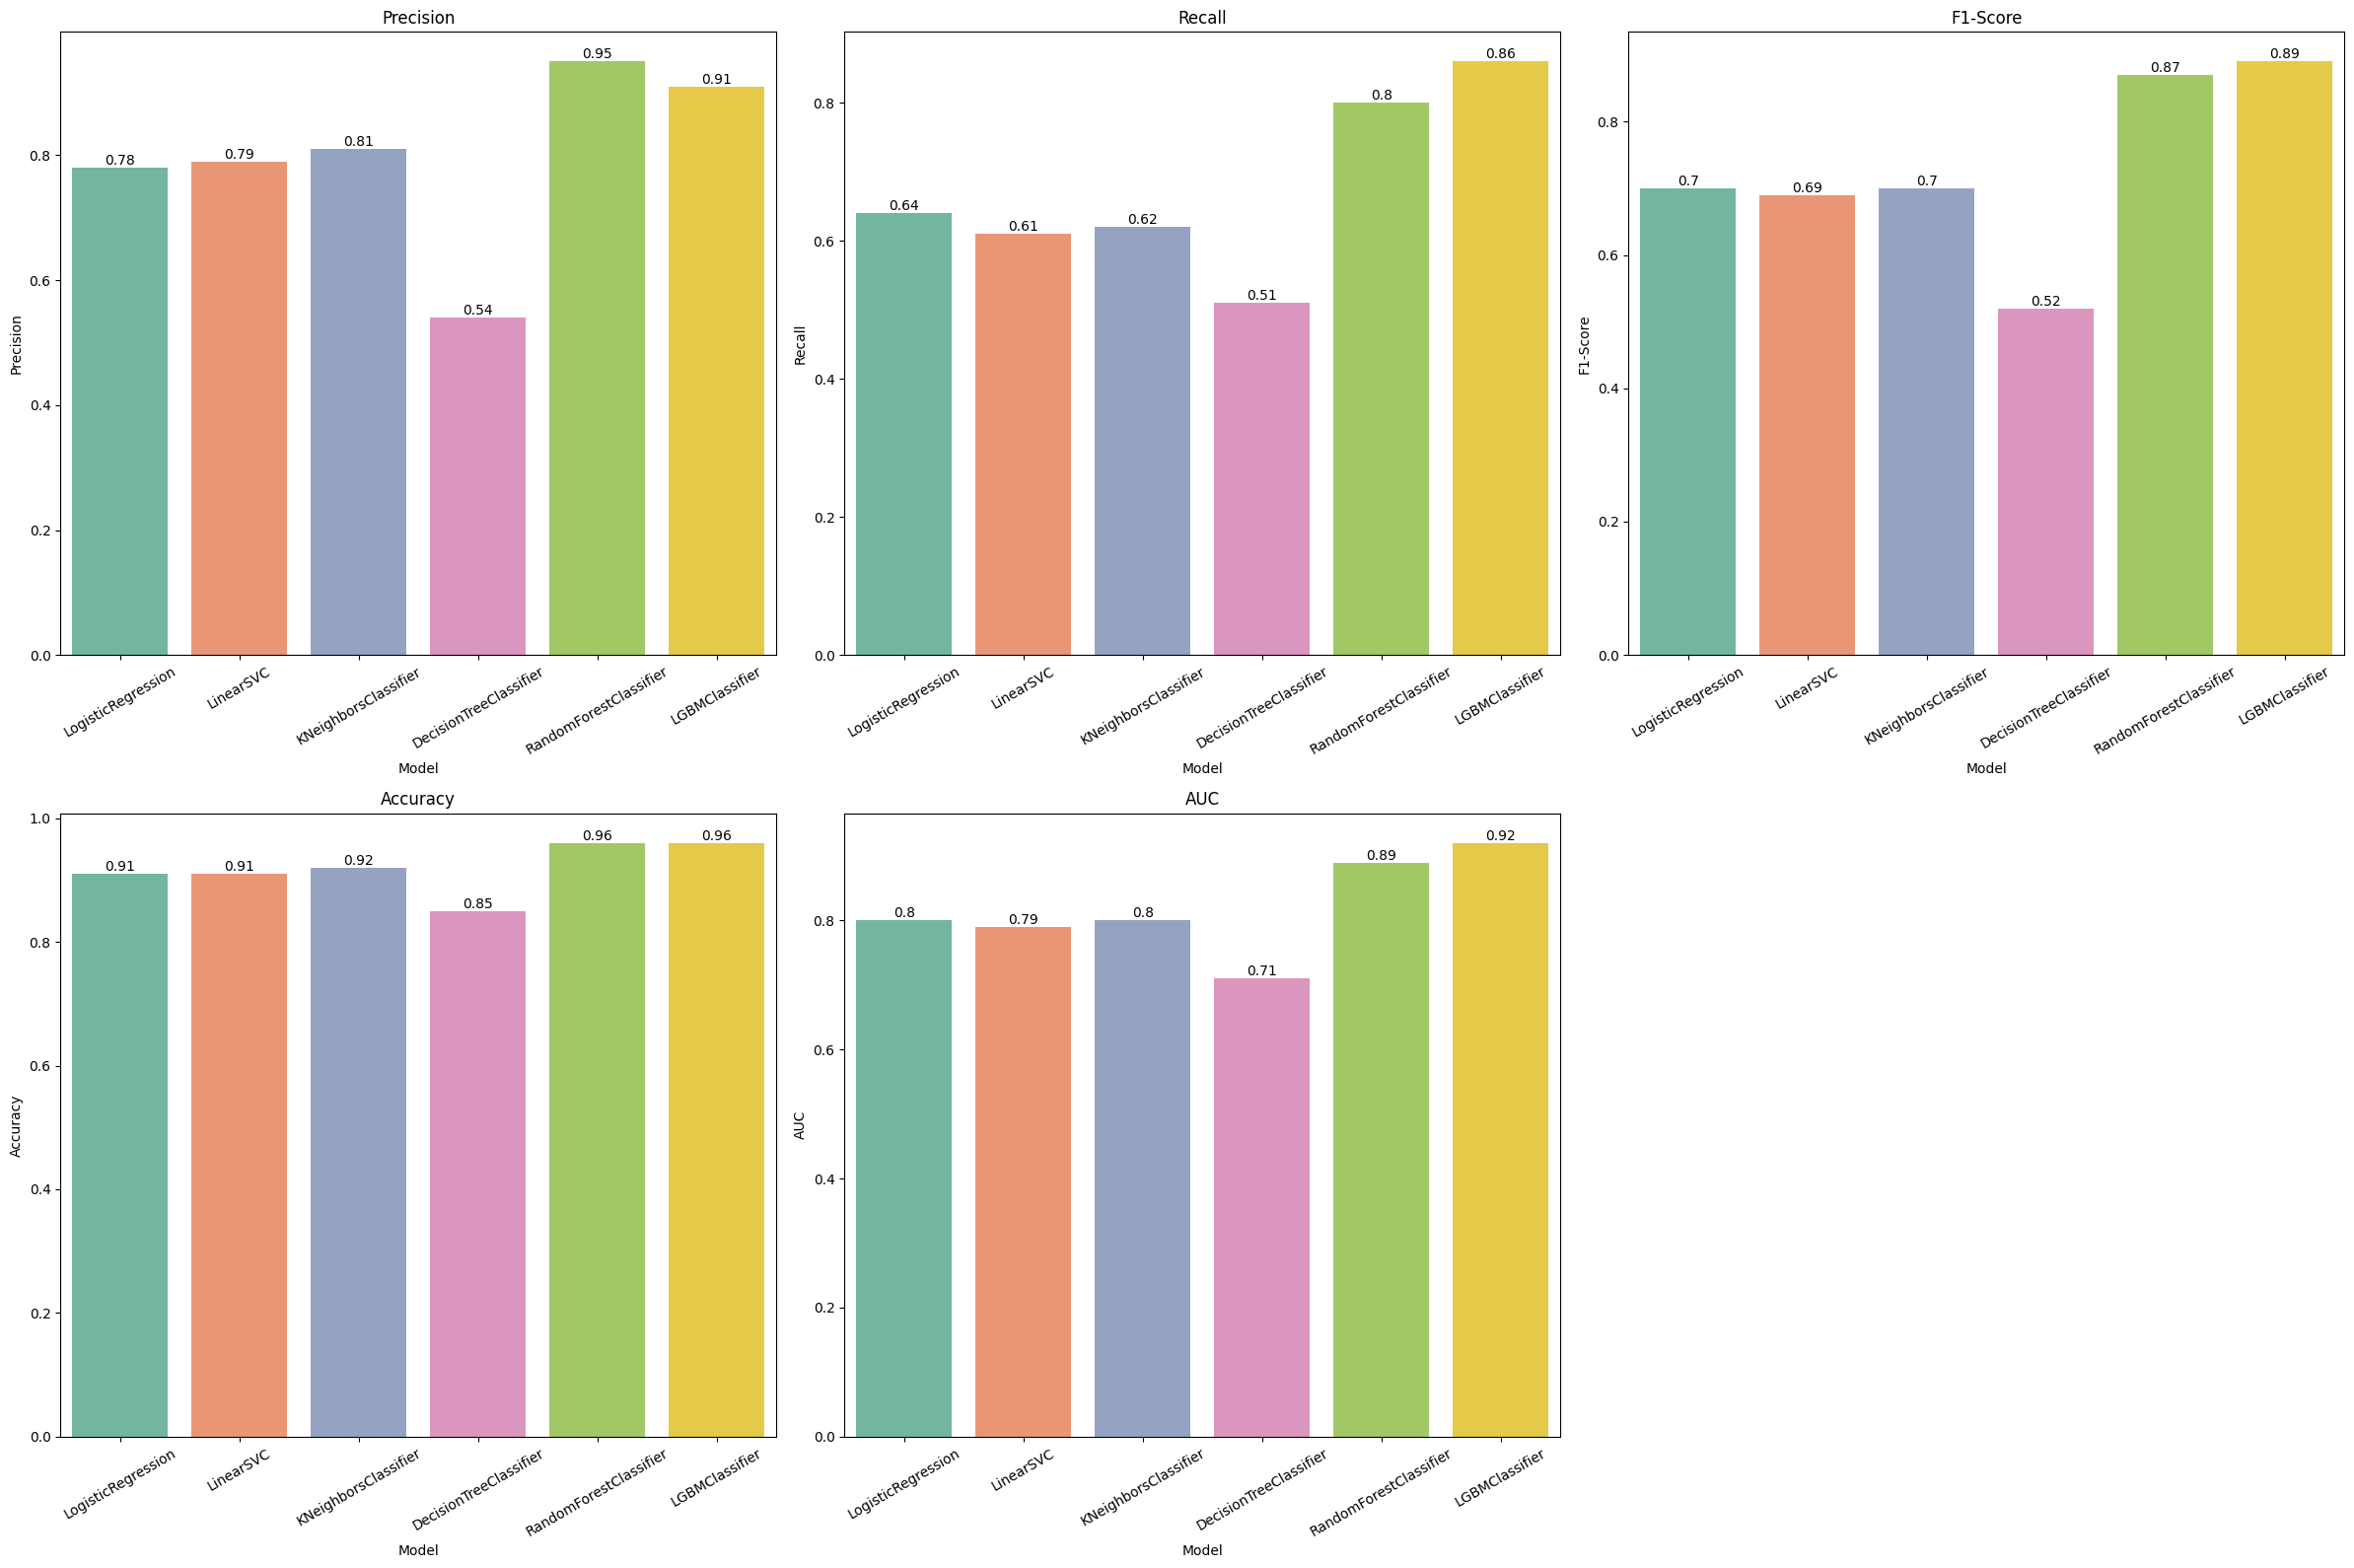

In [4]:
feats = results.columns[1:]

num_cols = len(feats)
num_rows = num_cols // 3 + (num_cols % 3 > 0)

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(24, 16))

for i, feat in enumerate(feats):
    row = i // 3
    col = i % 3

    ax = axes[row, col] if num_rows > 1 else axes[col]

    ax = sns.barplot(x="Model", y=feat, data=results, palette="Set2", ax=ax, ci=None)
    ax.set_title(feat)
    
    for container in ax.containers:
        ax.bar_label(container)
        ax.set_xticklabels(results["Model"], rotation=30)

if num_cols < len(axes.flat):
    for j in range(num_cols, len(axes.flat)):
        fig.delaxes(axes.flat[j])

plt.tight_layout()
plt.show()

##### Evaluating the best model

In [5]:
results[results["Model"] == "LGBMClassifier"]

,Model,Precision,Recall,F1-Score,Accuracy,AUC
5,LGBMClassifier,0.91,0.86,0.89,0.96,0.92


In [6]:
X_test = pd.read_csv("./artifacts/test_tree.csv", index_col=0)
y_test = pd.read_csv("./artifacts/test_target.csv", index_col=0)

with open("./artifacts/LGBMClassifier.pkl", "rb") as file:
    model = pickle.load(file)

In [7]:
y_pred = model.predict(X_test)
churn_probas = model.predict_proba(X_test)[:, 1]

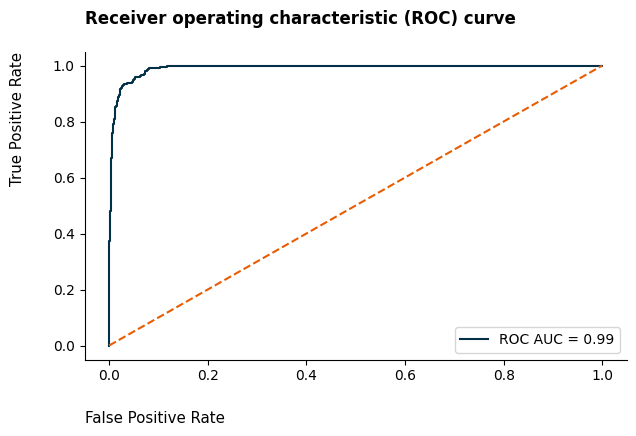

In [8]:
fpr, tpr, thresholds = roc_curve(y_test, churn_probas)
roc_auc = roc_auc_score(y_test, churn_probas)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}', color='#023047')
ax.plot([0, 1], [0, 1], linestyle='--', color='#e85d04') 
ax.set_xlabel('False Positive Rate', fontsize=10.8, labelpad=20, loc='left')
ax.set_ylabel('True Positive Rate', fontsize=10.8, labelpad=20, loc='top')
ax.set_xticks(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
ax.set_yticks(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
ax.set_title('Receiver operating characteristic (ROC) curve', fontweight='bold', fontsize=12, pad=20, loc='left')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

plt.show()

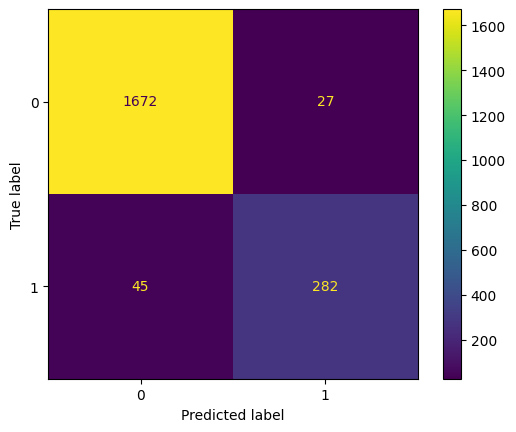

In [9]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, display_labels=model.classes_
)
disp.plot()
plt.show()

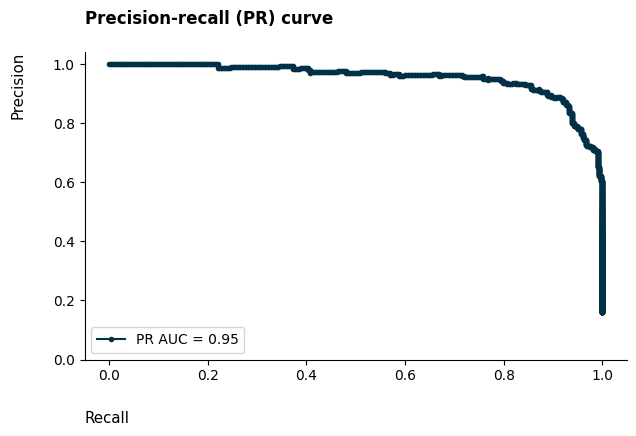

In [10]:
p, r, _ = precision_recall_curve(y_test, churn_probas)
pr_auc = auc(r, p)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(r, p, marker='.', label=f'PR AUC = {pr_auc:.2f}', color='#023047')
ax.set_xlabel('Recall', fontsize=10.8, labelpad=20, loc='left')
ax.set_ylabel('Precision', fontsize=10.8, labelpad=20, loc='top')
ax.set_xticks(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
ax.set_yticks(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
ax.set_title('Precision-recall (PR) curve', fontweight='bold', fontsize=12, pad=20, loc='left')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.show()

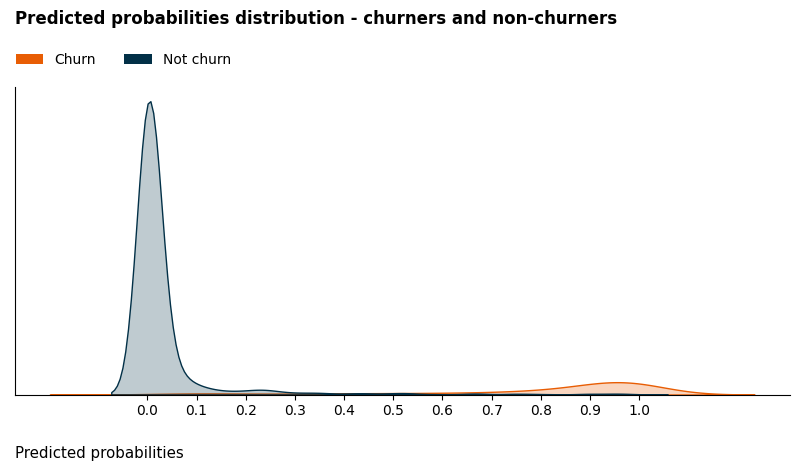

In [11]:
probas_df = pd.DataFrame({'churn_probability': churn_probas, 'churn': y_test['churn_flag'].values})

fig, ax = plt.subplots(figsize=(10, 4))
sns.kdeplot(data=probas_df, x='churn_probability', hue='churn', fill=True, ax=ax, palette=['#023047', '#e85d04'])
ax.set_title('Predicted probabilities distribution - churners and non-churners', fontweight='bold', fontsize=12, pad=45, loc='left')
ax.set_xlabel('Predicted probabilities', fontsize=10.8, labelpad=20, loc='left')
ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'],
            )
ax.yaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

handles = [plt.Rectangle((0,0), 0.1, 0.1, fc='#e85d04', edgecolor = 'none'),
        plt.Rectangle((0,0), 0.1, 0.1, fc='#023047', edgecolor = 'none')]
labels = ['Churn', 'Not churn']
    
ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.14, 1.15), frameon=False, ncol=2, fontsize=10)
plt.show()

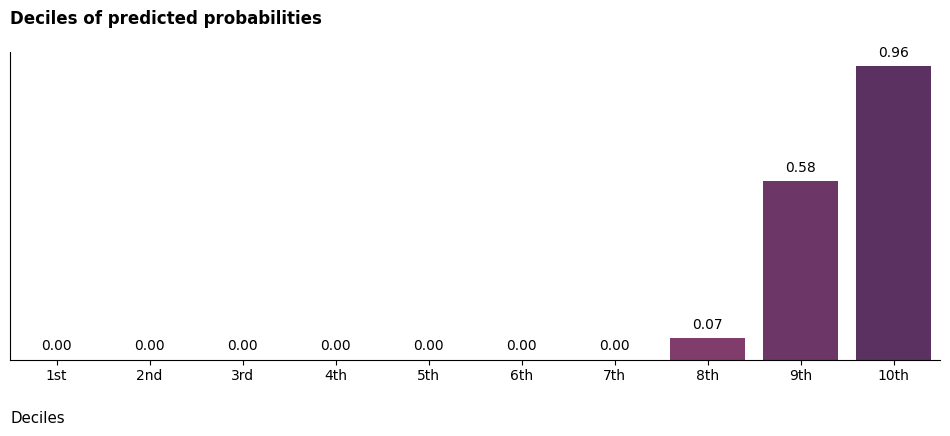

In [12]:
churn_probas = model.predict_proba(X_test)[:, 1]

noise = np.random.uniform(0, 0.0001, size=churn_probas.shape)
churn_probas += noise

probas_df = probas_df.sort_values(by='churn_probability', ascending=True)

probas_df['deciles'] = pd.qcut(probas_df['churn_probability'], q=10, labels=False, duplicates='drop')

decile_df = probas_df.groupby(['deciles'])['churn'].mean().reset_index().rename(columns={'churn': 'churn_rate'})

fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x="deciles", y="churn_rate", data=decile_df, palette='flare')
ax.set_xlabel('Deciles', fontsize=10.8, labelpad=20, loc='left')
ax.set_ylabel('Churn rate', fontsize=10.8, labelpad=20, loc='top')
ax.set_xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], labels=['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th'])
ax.set_title('Deciles of predicted probabilities', fontweight='bold', fontsize=12, pad=20, loc='left')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_visible(False)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

##### Model's analysis with SHAP values

SHAP (SHapley Additive exPlanations) is a method used in machine learning to explain the predictions made by complex models. It helps you understand how much each feature (input variable) contributes to a model's prediction for a given instance.

This method calculates the impact of each feature on the prediction by comparing what the model would predict with and without each feature. It uses a method inspired by cooperative game theory (Shapley values) to fairly distribute the contribution among all features.

**How SHAP works practically?**

1. Imagine each feature of the model is like a player in a game, and the goal is to make a prediction.
2. SHAP calculates how much each feature "helps" the model to make its prediction by considering all possible combinations of features.
3. It assigns a SHAP value to each feature, which tells you whether it increased or decreased the prediction, and by how much.

By using SHAP, we can answer the question "Why did this model predict that this person will churn?"

In [13]:
from shap import Explainer
import shap

explainer = Explainer(model)
shap_values = explainer(X_test)
np.shape(shap_values.values)

(2026, 52)

In [47]:
X_test_rst_idx = X_test.reset_index()
y_test_rst_idx = y_test.reset_index()
X_test_rst_idx.drop(columns=['index'], inplace=True)
y_test_rst_idx.drop(columns=['index'], inplace=True)


churned = y_test_rst_idx[y_test_rst_idx['churn_flag'] == 1].sample(1).index
non_churned = y_test_rst_idx[y_test_rst_idx['churn_flag'] == 0].sample(1).index

churned, non_churned

(Index([536], dtype='int64'), Index([1490], dtype='int64'))

In [33]:
# indexes = 536 (churned), 1490 (non churned)
X_test_rst_idx[(X_test_rst_idx.index == churned[0]) | (X_test_rst_idx.index == non_churned[0])]

,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,products_per_dependent,trans_amt_per_dependent,trans_ct_per_dependent,trans_amt_per_products,trans_ct_per_products,avg_trans_amt,credit_util_rate,proportion_inactive_months,products_per_tenure,products_per_contacts,dependents_per_contacts,trans_ct_per_contacts,products_per_inactivity,dependents_per_inactivity,trans_ct_per_inactivity,trans_amt_per_credit_limit,age_per_tenure,trans_ct_per_tenure,trans_amt_per_tenure,total_spending,inactivity_contacts,education_income_levels,gender_M,education_level_Doctorate,education_level_Graduate,education_level_High School,education_level_Post-Graduate,education_level_Uneducated,marital_status_Married,marital_status_Single,marital_status_Unknown,income_category_$40K - $60K,income_category_$60K - $80K,income_category_$80K - $120K,income_category_Less than $40K,card_category_Gold,card_category_Platinum,card_category_Silver
672,26,0,13,6,3,2,2347.0,0,2347.0,0.863,2595,56,0.333,0.0,0.0,0.0,0.0,432.5,9.333333,46.339287,0.0,0.230769,0.461538,3.0,0.0,28.0,2.0,0.0,18.666666,1.105667,2.000000,4.307692,199.61539,2595,5,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1059,51,2,42,2,4,2,14938.0,0,14938.0,0.758,8192,80,0.778,0.0,1.0,4096.0,40.0,4096.0,40.000000,102.400000,0.0,0.095238,0.047619,1.0,1.0,40.0,0.5,0.5,20.000000,0.548400,1.214286,1.904762,195.04762,8192,6,5,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


There are 52 features in all. Every feature has a matching SHAP value for each one.

In binary classification, results are interpreted using log-odds, which is the logarithm of the ratio between the probability of an event happening versus not happening. Logarithms convert odds to a linear scale. Positive SHAP values increase the log-odds, raising the probability of the event (e.g., churning), while negative SHAP values decrease it.

We can obtain the probability of churning from the log-odds by simply using the logistic function, defined as: **P = 1 / (1 + e^−logodds)** 

We will be able to see how each attribute contributes to the prediction for both positive (churner) and negative (non-churner) instances using the waterfall display.

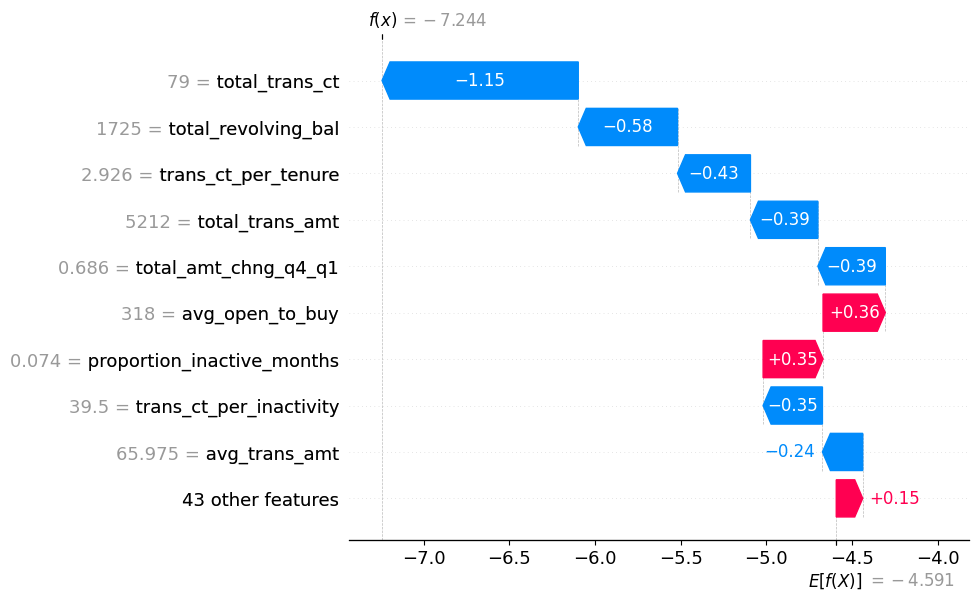

In [48]:
shap.plots.waterfall(shap_values[non_churned[0]])

- This customer did not churn, with the estimated probability of churning being approximately 0.0714%.
- We can observe that the number of transactions made in the last 12 months, which is 79 in this case, decreased the log-odds of churning by 1.15. On the other hand, the average amount open to buy, which is $318.00, increased the log-odds of churning by 0.36. 
    - This aligns with our findings that a higher number of transactions lowers the risk of churn, and many churners were concentrated among those with low average open-to-buy values and inactive users for 1 to 3 months.
- Notice how the features created during feature engineering, like *proportion_inactive_months*, *trans_ct_per_ternure* and *trans_ct_per_inactivity*, impacted the log-odds of churning either positively or negatively.

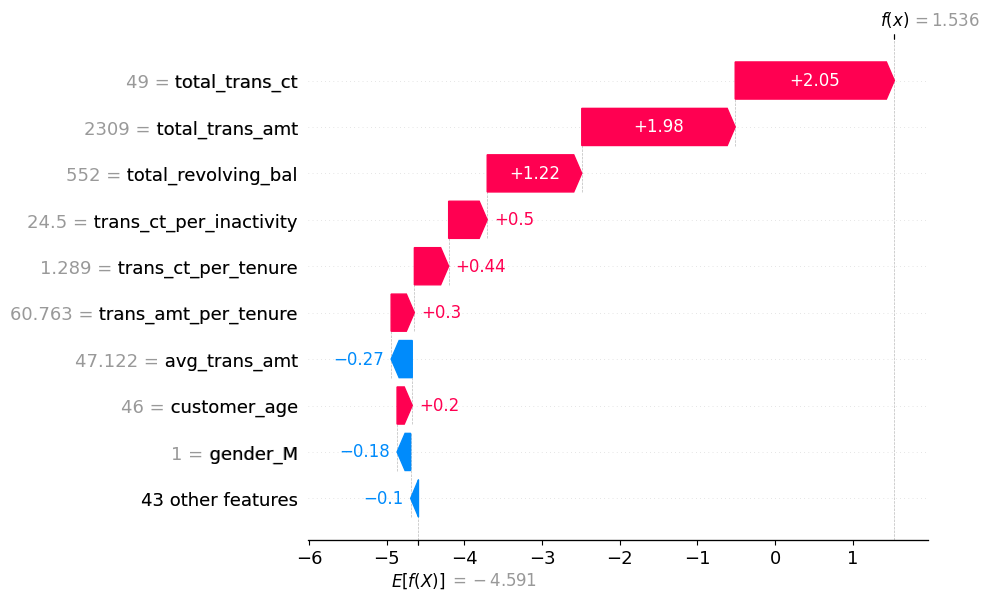

In [49]:
shap.plots.waterfall(shap_values[churned[0]])

- This customer has churned, with an estimated probability of churning at around 82%, based on the logistic function.
- We can see that the number of transactions, total transaction amount, and total revolving balance have increased the log-odds by 2.05, 1.98, and 1.22, respectively.
    - This aligns with our earlier findings, where a low number of transactions was linked to a higher churn rate. Similarly, a low total transaction amount matches our previous exploratory data analysis (EDA) insights. Lastly, regarding the total revolving balance, we had observed that customers with balances below $600 or above $2,400 were more likely to churn.

We can now see which characteristics are most significant using the bar plot. 

The average absolute SHAP value for each feature is plotted below, allowing us to see which features have a greater (positive or negative) impact on the model predictions.

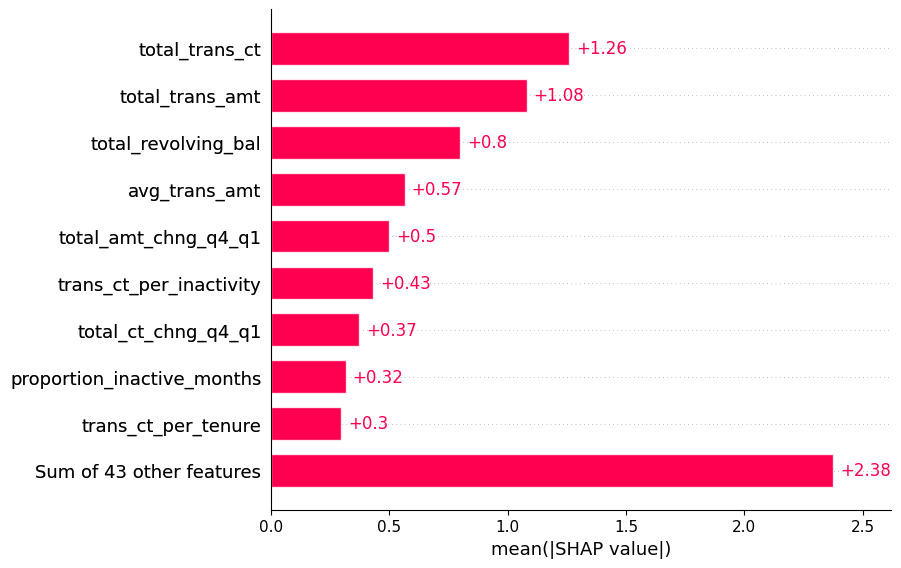

In [50]:
shap.plots.bar(shap_values)

As expected, the number of transactions and the transaction amount in the last 12 months are the most significant features. This aligns with our EDA, where these variables clearly distinguished between churners and non-churners.

Additionally, the features created during the feature engineering phase also ranked among the most important, highlighting the value of this process in enhancing the performance of a machine learning model. Examples include *trans_ct_per_inactivity*, *avg_trans_amt*, *proportion_inactive_months*, and *trans_ct_per_tenure*.

We can now see the link between the characteristics and the model prediction thanks to the beeswarm graphic.

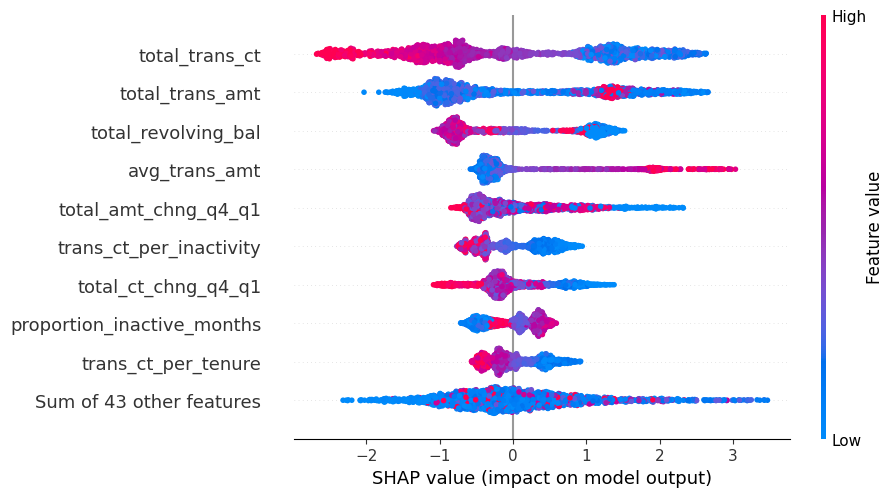

In [51]:
shap.plots.beeswarm(shap_values)

- It is evident that lower transaction counts in the past 12 months positively influence the log-odds of churning, thereby increasing the probability of churn, while higher transaction counts have a negative impact.
- Interestingly, higher average transaction amounts tend to positively affect the log-odds of churning, raising the likelihood of churn, whereas lower amounts generally have a negative impact.

#### 6. Financial Results

To demonstrate the value of the project, I will quantify the model's performance in terms of financial outcomes for the bank. Using our present data and the confusion matrix as a guide, I will accomplish this.

I lack the detailed facts necessary to determine the precise financial gain. Nonetheless, collecting fees on the outstanding sum that cardholders carry from month to month, also referred to as the total revolving debt, is a typical way for credit card firms to make money. I will thus compute the financial benefit using the standard assumption that the bank's charge is 18%.

In light of this, I will consider the following costs and advantages when estimating the financial gain offered by the model:

- Retention cost per client (false positive):
    - This charge relates to clients that wouldn't churn but were mistakenly identified by the model as churners, resulting in costs for the bank to keep them. I will specifically lower the cost from 18% to 10% in order to keep the customer, however this 8% discount will result in a loss of revenue.
- Revenue loss per churner (false negative):
    - This expense results from the model's failure to accurately identify customers who are actually likely to churn, which causes the bank to lose both these clients and the related income. This charge will include the full 18% fee that is charged to the unpaid amounts.
- Financial gain with the retention of a customer correctly predicted as a churner (true positive):
    - By using the 10% charge on total revolving balances as our retention approach, we are able to keep both the money they provide and the model's correct prediction of a churner.

In [54]:
financial_results = X_test[['total_revolving_bal']]
financial_results['churn_flag'] = y_test
financial_results['predicted'] = y_pred

Get separate datasets for false positives, false negatives and true positives.

In [55]:
fp_data = financial_results.loc[(financial_results['churn_flag'] == 0) & (financial_results['predicted'] == 1)]
fn_data = financial_results.loc[(financial_results['churn_flag'] == 1) & (financial_results['predicted'] == 0)]
tp_data = financial_results.loc[(financial_results['churn_flag'] == 1) & (financial_results['predicted'] == 1)]

Estimate the costs and gain.

In [56]:
fp_data['fp_cost'] = fp_data['total_revolving_bal']*1.18 - fp_data['total_revolving_bal']*1.10
fn_data['fn_cost'] = fn_data['total_revolving_bal']*1.18
tp_data['tp_gain'] = tp_data['total_revolving_bal']*1.10

Finally, the financial result given by the model will be the difference between the gain and the costs.

In [57]:
financial_gain = tp_data['tp_gain'].sum() - fp_data['fp_cost'].sum() - fn_data['total_revolving_bal'].sum()
print(f'The model provides a financial gain of ${financial_gain:.1f}')

The model provides a financial gain of $159157.3


#### Conclusion

The model achieves a strong performance in classifying churn customers. When considering its potential financial impact, the model is projected to generate a gain of $159,157.